### Start

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, mannwhitneyu
import shap
import xgboost
import sklearn

c:\Users\pu.0580\Desktop\Projects\Projects\bacilli_turin_boattini_2024\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('../data/neg_bacilli_turin_2024.txt', delimiter='\t')
print(df)
for name in df.columns:
    print(name)

    pat_id  STEMA  Achromobacter  Ochrobactrum  Aeromonas  Burkolderia  Other  \
0        1    NaN            1.0           NaN        NaN          NaN    NaN   
1        2    NaN            1.0           NaN        NaN          NaN    NaN   
2        3    NaN            1.0           NaN        NaN          NaN    NaN   
3        4    NaN            NaN           1.0        NaN          NaN    NaN   
4        5    NaN            NaN           NaN        NaN          1.0    NaN   
..     ...    ...            ...           ...        ...          ...    ...   
58      59    NaN            NaN           NaN        NaN          NaN    1.0   
59      60    1.0            NaN           NaN        NaN          NaN    NaN   
60      61    1.0            NaN           NaN        NaN          NaN    NaN   
61      62    1.0            NaN           NaN        NaN          NaN    NaN   
62      63    NaN            NaN           1.0        NaN          NaN    NaN   

    Polymicrobial  Polymicr

### Missing Data

In [1]:
print("Total missing # :", df.isna().sum().sum())
print("Total missing % :", 100* df.isna().sum().sum() / (df.shape[0]*df.shape[1]) )
df.fillna(0, inplace=True)
print("Total missing # :", df.isna().sum().sum())
print("Total missing % :", 100* df.isna().sum().sum() / (df.shape[0]*df.shape[1]) )

NameError: name 'df' is not defined

### Summary Stats

In [ ]:
def calculate_se_proportion(p, n):
    return np.sqrt((p * (1 - p)) / n).round(2)

In [ ]:
def create_summary_table(df):
    """ Generate summary table.
    Args:
    df (DataFrame): The DataFrame for which to generate the summary table.
    Returns:
    DataFrame: The summary table."""

    # Generate summary statistics for ALL columns
    summary_table = df.describe()
    # Transpose the summary table
    summary_table = summary_table.T
    # Round all values to two decimal points
    summary_table = summary_table.round(2)
    # Create 'Mean ± Std' column
    summary_table['Mean ± Std'] = summary_table.apply(lambda row: f"{row['mean']} ± {row['std']}", axis=1)
    # Create 'Median [IQR]' column
    summary_table['Median [IQR]'] = summary_table.apply(lambda row: f"{row['50%']} [{row['25%']}-{row['75%']}]", axis=1)
    # Create 'Proportion ± SE' column
    summary_table['Proportion ± SE'] = summary_table.apply(lambda row: f"{row['mean']} ± {calculate_se_proportion(row['mean'], row['count'])}", axis=1)
    # Create 'SE_Error_Flag' column
    summary_table['SE_Error_Flag'] = summary_table['Proportion ± SE'].apply(lambda row: 1 if 'nan' in str(row) else 0)
    # Reset the index
    summary_table.reset_index(inplace=True)
    # Create 'Row_Number' column
    summary_table['Row_Number'] = summary_table.index + 1
    # Drop unnecessary columns
    summary_table.drop(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], axis=1, inplace=True)

    return summary_table

In [ ]:
summary_table = create_summary_table(df)
summary_table.to_csv('../data/summary_table.csv')
summary_table

### Positive >2 cultures  || +50%

### Summary Stats + Fisher's Exat Test | Wilcoxon/Mann-Whitney Test

In [ ]:
df_cult_pos = df[df['Positive_2culture_50perc'] == 1] # 43 out of 63
summary_table = create_summary_table(df_cult_pos)
summary_table.to_csv('../data/summary_table_cult_pos.csv')

In [ ]:
df_cult_neg = df[df['Positive_2culture_50perc'] == 0] # 20 out of 63
summary_table = create_summary_table(df_cult_neg)
summary_table.to_csv('../data/summary_table_cult_neg.csv')

In [ ]:
exclude_cols = ['Positive_2culture_50perc', 'pat_id']
binary_results = []
numeric_results = []

In [ ]:
for col in df.columns:
    if col not in exclude_cols:
        if df[col].nunique() <= 2:
            filtered_col = df[col].dropna().astype(int)
            if filtered_col.nunique() == 2:
                contingency_table = pd.crosstab(df['Positive_2culture_50perc'], filtered_col)
                odds_ratio , p_value = fisher_exact(contingency_table)
                binary_results.append((col, odds_ratio, p_value))
            else:
                print(f"Warning: Colunm '{col}' does not exactly 2 unique values. Dropping it..." )
        else:
            group_1 = df[df['Positive_2culture_50perc'] == 1][col]
            group_2 = df[df['Positive_2culture_50perc'] == 0][col]
            _ , p_value = mannwhitneyu(group_1, group_2, alternative='two-sided')
            numeric_results.append((col, p_value))

In [ ]:
print("Numeric Variables (Wilcoxon/Mann-Whitney Test): ")
for result in numeric_results:
    print(f"{result[0]} , p-value: {result[1]}" )

In [ ]:
print("Binary Variables (Fisher's Exact Test): ")
for result in binary_results:
    print(f"{result[0]} - Odds Ratio: {result[1]}, p-value: {result[2]}" )

### In-Hospital Mortality

### Summary Stats + Fisher's Exat Test | Wilcoxon/Mann-Whitney Test

In [ ]:
df_hosp_mort_pos = df[df['Mortality_hospital'] == 1] # 10 out of 63
summary_table = create_summary_table(df_hosp_mort_pos)
summary_table.to_csv('../data/summary_table_hosp_mort_pos.csv')

In [ ]:
df_hosp_mort_neg = df[df['Mortality_hospital'] == 0] # 53 out of 63
summary_table = create_summary_table(df_hosp_mort_neg)
summary_table.to_csv('../data/summary_table_hosp_mort_neg.csv')

In [ ]:
exclude_cols = ['Mortality_hospital', 'pat_id', 'Amoxicillin_clavulanate_including', 'Metronidazole_including', 'Mortality_30_days', 'Mortality_14_days']
binary_results = []
numeric_results = []

In [ ]:
for col in df.columns:
    if col not in exclude_cols:
        if df[col].nunique() <= 2:
            filtered_col = df[col].dropna().astype(int)
            if filtered_col.nunique() == 2:
                contingency_table = pd.crosstab(df['Mortality_hospital'], filtered_col)
                odds_ratio , p_value = fisher_exact(contingency_table)
                binary_results.append((col, odds_ratio, p_value))
            else:
                print(f"Warning: Colunm '{col}' does not exactly 2 unique values. Dropping it..." )
        else:
            group_1 = df[df['Mortality_hospital'] == 1][col]
            group_2 = df[df['Mortality_hospital'] == 0][col]
            _ , p_value = mannwhitneyu(group_1, group_2, alternative='two-sided')
            numeric_results.append((col, p_value))

In [ ]:
print("Numeric Variables (Wilcoxon/Mann-Whitney Test): ")
for result in numeric_results:
    print(f"{result[0]} , p-value: {result[1]}" )

In [ ]:
print("Binary Variables (Fisher's Exact Test): ")
for result in binary_results:
    print(f"{result[0]} - Odds Ratio: {result[1]}, p-value: {result[2]}" )

### Model: XGBoost

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, mannwhitneyu
import shap
import xgboost
import sklearn


In [ ]:
df = pd.read_csv('../data/neg_bacilli_turin_2024.txt', delimiter='\t')
df.fillna(0, inplace=True)

In [ ]:
columns_to_drop = ['pat_id', 'Amoxicillin_clavulanate_including', 'Metronidazole_including', 'Mortality_30_days', 'Mortality_14_days']
df = df.drop(columns=columns_to_drop)

In [ ]:
y = df['Mortality_hospital']
X = df.drop(columns=['Mortality_hospital'])


In [ ]:
X100 = shap.utils.sample(X, 100)

In [ ]:
df.shape

(63, 75)

In [ ]:
model = xgboost.XGBClassifier(nestimators=100, max_depth=2).fit(X, y)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

In [ ]:
shap_values.display_data = X.values

In [ ]:
shap.plots.bar(shap_values)


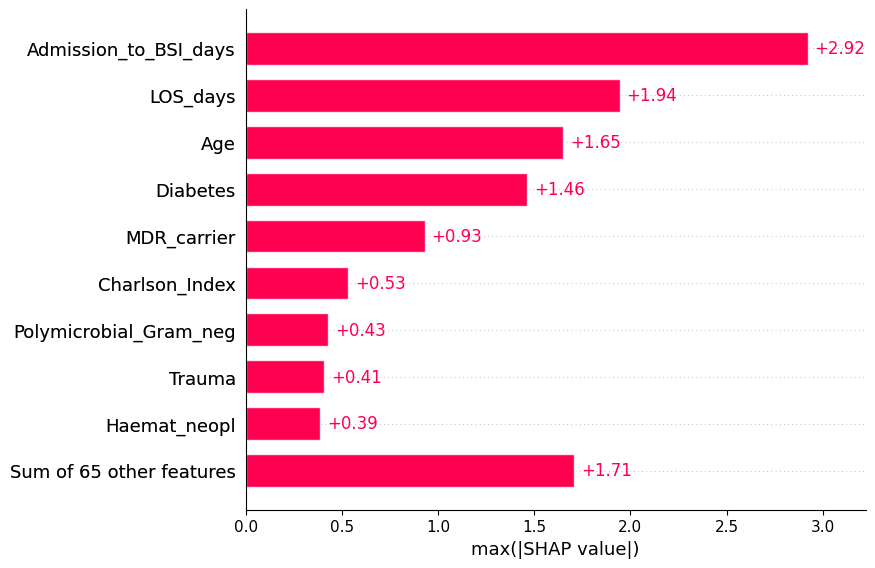

In [ ]:
shap.plots.bar(shap_values.abs.max(0))


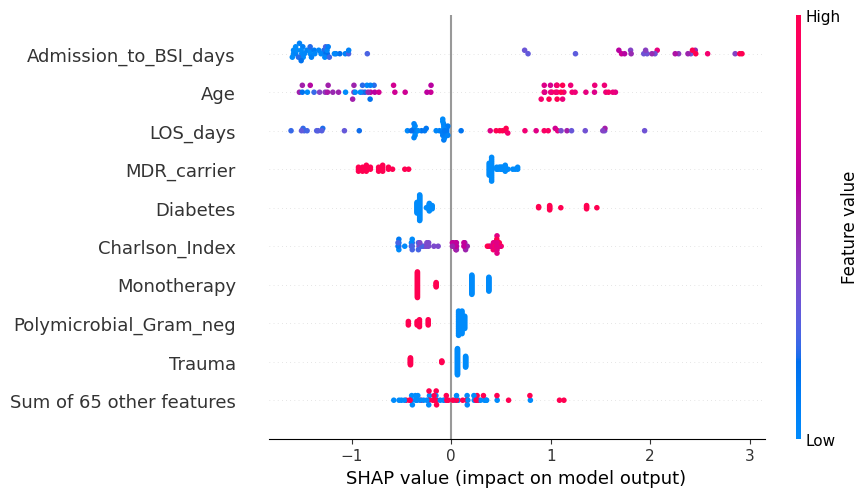

In [ ]:
shap.plots.beeswarm(shap_values)


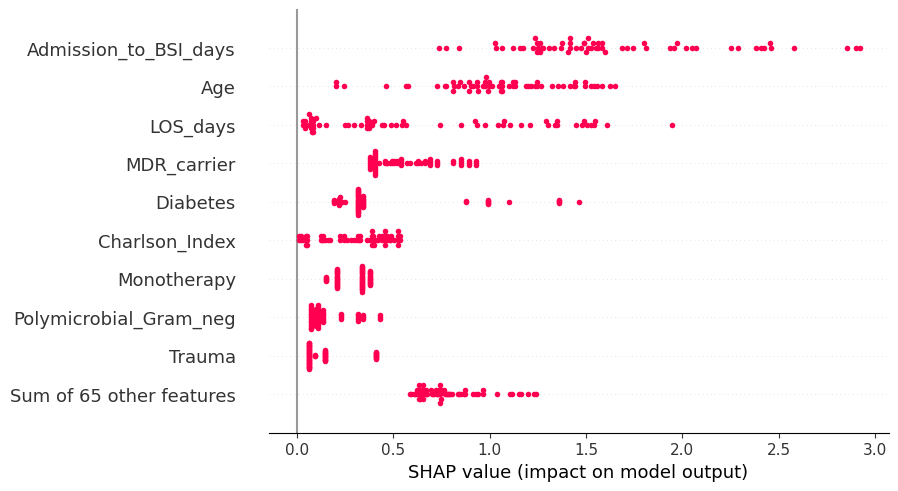

In [ ]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")